In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras. preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#from sklearn.utils import shuffle
#from adabound import AdaBound
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
#import math
import cv2
import os

In [4]:
#Preprocessing specifications/definitions
img_height = 200
img_width = 200
#img_batch_size = 4
no_channels = 3

IMG_DIR ='coarse21/Images'
CSV_DIR ='coarse21/labels1.csv'

csv_df = pd.read_csv(CSV_DIR)

csv_df = csv_df.sample(frac=1)

#pd.set_option('display.max_rows', None)
csv_df = pd.get_dummies(csv_df, columns=['Coarse','Fine'], drop_first=True, prefix=['Coarse', 'Fine'])


def test_1(batch_size, num_samples):
    
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_df = csv_df.iloc[offset:offset+batch_size] #splits the rows into batches
            batch_df = batch_df.values

            images = []
            out1 = []
            out2 = []

            for row in batch_df:
                #images
                img = image.load_img(IMG_DIR+'//'+ row[0], target_size= (200,200))
                X = image.img_to_array(img)
                X = X/255
                X = np.expand_dims(X,axis= 0)
                imagen = np.vstack([X])

                #1st output
                train_y1= row[1]
                train_y1 = np.asarray(train_y1).astype('float32')
                train_y1 = np.expand_dims(train_y1, axis = 0)
                #2nd output
                train_y2= row[2:5]
                train_y2 = np.asarray(train_y2).astype('float32')
                train_y2 = np.expand_dims(train_y2, axis = 0)

                examples = np.array(imagen)
                labels1 = np.array(train_y1)
                labels2 = np.array(train_y2)
                yield(examples,[labels1, labels2])

#Defining the no. of generated classes for each branch
coarse2_classes = 1
fine_classes = 3 

In [7]:
#Block 1
input_shape =(img_height,img_width,no_channels)
img_dimension = Input(shape= input_shape, name='input_dim')
#1st convolution and its input tensor
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv1')(img_dimension)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd convolution
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#1st pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool')(layer)

#Block 2
#3rd convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#4th convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool')(layer)

#Block 3
#5th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#6th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#7th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#3rd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool')(layer)

#Coarse 2 branch fc layer
c2_branch = tf.keras.layers.Flatten()(layer)
#c2 branch's 1st dense layer
c2_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='c2_dense1')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.2)(c2_branch)
#c2 branch's 2nd dense layer
c2_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='c2_dense2')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.2)(c2_branch)
#c2 branch's output layer
c2_branch_out = tf.keras.layers.Dense(coarse2_classes, activation= 'sigmoid', name='c2_last_dense_layer')(c2_branch)

#Block 4
#8th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#9th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#10th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#4rd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool')(layer)

#Block 5
#11th convolution

layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#12th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#13th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)

#Fine branch fc layer
fine_branch = tf.keras.layers.Flatten()(layer)
#fine branch's 1st dense layer
fine_branch = tf.keras.layers.Dense(4096,activation= 'relu', name='fine_dense1')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.2)(fine_branch)
#fine branch's 2nd dense layer
fine_branch = tf.keras.layers.Dense(4096,activation= 'relu', name='fine_dense2')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.2)(fine_branch)
#fine branch's output layer
fine_branch_out = tf.keras.layers.Dense(fine_classes, activation= 'softmax', name='fine_last_dense_layer')(fine_branch)

#Puting the learning model together
model = tf.keras.Model(inputs= img_dimension, outputs= [c2_branch_out, fine_branch_out], name= 'edp_eb_hierarchy')

In [12]:
model.compile(loss= {'c2_last_dense_layer': 'binary_crossentropy', 'fine_last_dense_layer': 'categorical_crossentropy'},
             optimizer = RMSprop(lr=1e-05), #Adam(lr=1e-03),
             metrics =['accuracy'])

In [13]:
model.load_weights("exp1/ckpt1")

model_fit = model.fit(test_1(4, 156),
                      #batch_size=4,
                     verbose=1,
                      steps_per_epoch=156,
                     #callbacks=[cp_callback],
                     epochs= 20
                      #shuffle=True,
                      #batch_size=2
                     )

Epoch 1/20
156/156 [==============================] - 646s 4s/step - loss: 1.7651 - c2_last_dense_layer_loss: 0.6933 - fine_last_dense_layer_loss: 1.0718 - c2_last_dense_layer_accuracy: 0.5064 - fine_last_dense_layer_accuracy: 0.3910
Epoch 2/20
156/156 [==============================] - 637s 4s/step - loss: 1.7893 - c2_last_dense_layer_loss: 0.6946 - fine_last_dense_layer_loss: 1.0948 - c2_last_dense_layer_accuracy: 0.5064 - fine_last_dense_layer_accuracy: 0.4423
Epoch 3/20
156/156 [==============================] - 639s 4s/step - loss: 1.8298 - c2_last_dense_layer_loss: 0.6930 - fine_last_dense_layer_loss: 1.1369 - c2_last_dense_layer_accuracy: 0.5000 - fine_last_dense_layer_accuracy: 0.4103
Epoch 4/20
156/156 [==============================] - 638s 4s/step - loss: 1.8474 - c2_last_dense_layer_loss: 0.6934 - fine_last_dense_layer_loss: 1.1541 - c2_last_dense_layer_accuracy: 0.5128 - fine_last_dense_layer_accuracy: 0.4103
Epoch 5/20
156/156 [==============================] - 632s 4s/st

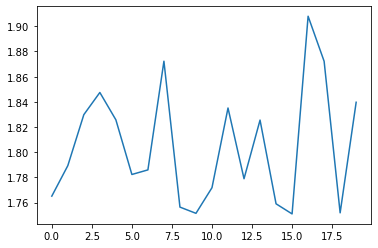

In [14]:
model.save_weights("exp/ckpt2")
plt.plot(model_fit.history['loss'])
plt.show()